In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anim

import crocosi.postp as pp

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


---

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#w = cluster.scale(jobs=2)
w = cluster.scale(2*28)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.1.103:59320 Dashboard: http://10.148.1.103:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

### common parameters

In [22]:
T = 30 # movie time period
di = 6
i0=5

---

In [32]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'
run = 'jet_wp5_ptb_m1_p4'

r = pp.Run(root_path+run, open_nc=['ave','surf'])
r['surf'] = r['surf'].rename({'time_instant': 'time'})

In [8]:
r['surf']

<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, time: 13391, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
  * y_rho                (y_rho) float32 -2000.0 2000.0 ... 2878000.0 2882000.0
    x_v                  (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    y_u                  (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_rho                (x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
  * y_v                  (y_v) float32 0.0 4000.0 8000.0 ... 2876000.0 2880000.0
  * x_u                  (x_u) float32 0.0 4000.0 8000.0 ... 1020000.0 1024000.0
    s_rho_slice0         float32 -0.01
  * time                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_instant_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter         (time) float64 2e+03 2e+03 ... 2.093e+03 2.093e+03
    time_counter_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    f_rho                (y_rho) float32 0.0001029676 ... 0.00014968839
    f_u                  (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f_v                  (y_v) float32 0.000103 0.0001030648 ... 0.000149656
Dimensions without coordinates: axis_nbounds
Data variables:
    ssh                  (time, y_rho, x_rho) float32 dask.array<chunksize=(1, 722, 258), meta=np.ndarray>
    T                    (time, y_rho, x_rho) float32 dask.array<chunksize=(1, 722, 258), meta=np.ndarray>
    u                    (time, y_rho, x_u) float32 dask.array<chunksize=(1, 722, 257), meta=np.ndarray>
    v                    (time, y_v, x_rho) float32 dask.array<chunksize=(1, 721, 258), meta=np.ndarray>
    w                    (time, y_rho, x_rho) float32 dask.array<chunksize=(1, 722, 258), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-12 14:21:23 GMT
    uuid:         051c8111-adec-44e2-b7da-29c730f0f436

--- 
### dev & utils

In [9]:
ds = r['surf'].isel(time=slice(0,T*24*6,di))
v = 'ssh'
vmin, vmax = -.6, .6

In [11]:
_ds = ds[v].isel(time=int(24*5*di/6))
_ds = _ds.assign_coords(x=_ds.x_rho/1e3, y=ds.y_rho/1e3)
_ds = _ds.persist()

Text(0.5, 1.0, 'day = 2005 / h = 0.17 hour ')

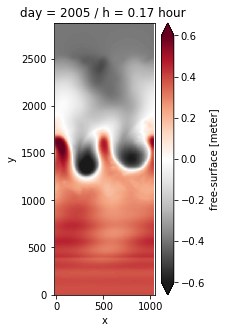

In [12]:
#plt_kw = {'cmap': 'RdGy_r', 'figsize': (5,5), 'subplot_kws':{'aspect': 'equal'}}

plt_kw = {'cmap': 'RdGy_r', 'extend':'both'}

figsize = (5,5)

d = int(_ds.time)
h = (_ds.time-d)*24
title = 'day = %d / h = %.2f hour '%(d, h)

xlim = (_ds.x.min(),_ds.x.max())
ylim = (_ds.y.min(),_ds.y.max())

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,2,1)
_ds.plot(x='x',y='y', 
         vmin=vmin, vmax=vmax, ax=ax, **plt_kw)
ax.axis('equal')
ax.set(xlim=xlim, ylim=ylim)
ax.set_title(title)

In [24]:
# could delete all figures beforehand
figdir = '/home1/scratch/aponte/figs/'
print('Figures directory: '+figdir)

def genfig(i, ds, v, overwrite=True, figsize=(4,5), **kwargs):
    
    figname = figdir+'%s_t%05d' %(v, i)+'.png'
            
    plt_kw = {'cmap': 'RdGy_r', 'extend':'both'}
    plt_kw.update(kwargs)
    
    _ds = ds[v].assign_coords(x=ds.x_rho/1e3, y=ds.y_rho/1e3)
    xlim = (_ds.x.min(),_ds.x.max())
    ylim = (_ds.y.min(),_ds.y.max())    
    
    if not os.path.isfile(figname) or overwrite:
        #
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            #
            d = int(_ds.time)
            h = (_ds.time-d)*24
            title = 'day = %d / h = %.2f hour '%(d, h)
            #
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(1,1,1)
            _ds.plot(x='x',y='y', ax=ax, **plt_kw)
            #ax.axis('equal')
            ax.set_aspect('equal', 'box')
            ax.set(xlim=xlim, ylim=ylim)
            ax.set_title(title)
            fig.savefig(figname, bbox_inches = 'tight')
            #plt.close(fig)
            plt.close()
            #
            m = 1.
    else:
        m = -1.
    return m

Figures directory: /home1/scratch/aponte/figs/


In [25]:
def spawn_computations(ds, plt_kw, Nt=None):
    if Nt is None:
        Nt = ds.time.size
    rg = range(0,Nt)
    II = np.array_split(rg,len(rg)/(28*2))
    print('%d loops to be done'%len(II))
    for I in II:
        print('  %d - %d'%(I[0],I[-1]))
        values = [delayed(genfig)(i, ds.isel(time=i), v, **plt_kw) for i in I]
        futures = client.compute(values)
        results = client.gather(futures)

---

### generate figures

In [34]:
v = 'ssh'
ds = r['surf'][v].isel(time=slice(i0,T*24*6,di)).to_dataset()
plt_kw = {'vmin': -.6, 'vmax': .6}

In [35]:
spawn_computations(ds, plt_kw)

12 loops to be done
  0 - 59
  60 - 119
  120 - 179
  180 - 239
  240 - 299
  300 - 359
  360 - 419
  420 - 479
  480 - 539
  540 - 599
  600 - 659
  660 - 719


---

### two simulations movies

In [23]:
runs = ['jet_wp5_ptb_m1_p2', 'jet_wp5_ptb_m1_p4']

R = []
for r in runs:
    _r = pp.Run(root_path+r, open_nc=['ave', 'surf'])
    _r['surf'] = _r['surf'].rename({'time_instant': 'time'})
    R.append(_r)
    print(r, _r['itideptb_full_Acos_mode'])
R

jet_wp5_ptb_m1_p2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
jet_wp5_ptb_m1_p4 [0.00e+00 1.46e-05 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00]


[Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_ptb_m1_p2
   datasets suffixes: grid / ave / surf,
 Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_ptb_m1_p4
   datasets suffixes: grid / ave / surf]

In [26]:
v = 'ssh'
ds = (R[1]['surf'][v].isel(time=slice(i0,T*24*6,di))
      -R[0]['surf'][v].isel(time=slice(i0,T*24*6,di))
      ).to_dataset()
plt_kw = {'vmin': -.05, 'vmax': .05}

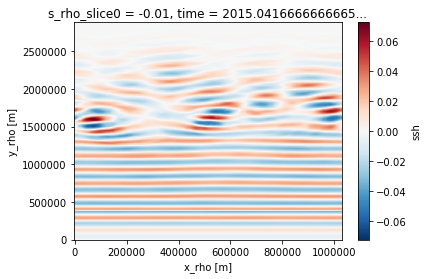

In [27]:
ds.ssh.isel(time=3*24*5).plot()

In [28]:
spawn_computations(ds, plt_kw)

12 loops to be done
  0 - 59
  60 - 119
  120 - 179
  180 - 239
  240 - 299
  300 - 359
  360 - 419
  420 - 479
  480 - 539
  540 - 599
  600 - 659
  660 - 719


---

In [29]:
runs = ['jet_wp5_ptb_m1_p0', 'jet_wp5_ptb_m1_p2', 'jet_wp5_ptb_m1_p4']

R = []
for r in runs:
    _r = pp.Run(root_path+r, open_nc=['ave', 'surf'])
    _r['surf'] = _r['surf'].rename({'time_instant': 'time'})
    R.append(_r)
    print(r, _r['itideptb_full_Acos_mode'])
R

jet_wp5_ptb_m1_p0 [ 0.00e+00 -1.46e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00]
jet_wp5_ptb_m1_p2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
jet_wp5_ptb_m1_p4 [0.00e+00 1.46e-05 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00]


[Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_ptb_m1_p0
   datasets suffixes: grid / ave / surf,
 Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_ptb_m1_p2
   datasets suffixes: grid / ave / surf,
 Run: /home/datawork-lops-osi/equinox/jetn/jet_wp5_ptb_m1_p4
   datasets suffixes: grid / ave / surf]

In [30]:
v = 'ssh'
ds = ( R[2]['surf'][v].isel(time=slice(i0,T*24*6,di))
      +R[0]['surf'][v].isel(time=slice(i0,T*24*6,di))
      -2*R[1]['surf'][v].isel(time=slice(i0,T*24*6,di))
      ).to_dataset()
plt_kw = {'vmin': -.01, 'vmax': .01}

In [31]:
spawn_computations(ds, plt_kw)

12 loops to be done
  0 - 59
  60 - 119
  120 - 179
  180 - 239
  240 - 299
  300 - 359
  360 - 419
  420 - 479
  480 - 539
  540 - 599
  600 - 659
  660 - 719


---

### two simulations, two axes movies

---

In [ ]:
cluster.close()